In [22]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [23]:
# Setting the path for the dataset
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

# Loading the prepared data
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

# Removing 'SalesID' and 'MachineID'
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

# Tabular Modelling Deep Dive

## Using a Neural Network
We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [24]:
# Setting the dependent variable and the ordinal features for ProductSize
dep_var = 'SalePrice'
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [25]:
# Reading in the raw processed data as a .csv
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

# Making 'ProductSize' an ordinal categorical feature
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)

# Taking the log of the SalePrice as we want our metric to be RMSLE
df_nn[dep_var] = np.log(df_nn[dep_var])

# Creating additional features from our saledate
df_nn = add_datepart(df_nn, 'saledate')

# Replacing years <1900 with 1950
df_nn.loc[df_nn['YearMade']<1900, 'YearMade'] = 1950

In [26]:
# Splitting the data into training and validation sets by setting aside the last 6 months as validation
cond = (df_nn.saleYear<2011) | (df_nn.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network:

In [27]:
# Masking the raw data with the relevant features from xs_final_time
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. In a neural net, a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

In [28]:
# Splitting the data into continuous and categorical features
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In this case, there's one variable that we absolutely do not want to treat as categorical: the `saleElapsed` variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen, but we want to be able to predict auction sale prices in the future. Let's verify that `cont_cat_split` did the correct thing.

In [29]:
cont_nn

['saleElapsed']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [30]:
df_nn_final[cat_nn].nunique()

YearMade                72
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
Enclosure                6
fiModelDesc           5059
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
ProductGroup             6
Track_Type               2
dtype: int64

The fact that there are two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests that they may contain similar, redundant information. Note that we would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Having a column with 5,000 levels means needing 5,000 columns in our embedding matrix, which would be nice to avoid if possible. Let's remove it as a predictor for our neural network:

In [31]:
cat_nn.remove('fiModelDescriptor')

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [32]:
# Applying tabular transformations
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [33]:
# Parsing the TabularPandas object into DataLoaders
dls = to_nn.dataloaders(1024)

As we've discussed, it's a good idea to set `y_range` for regression models, so let's find the min and max of our dependent variable:

In [34]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [35]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0003981071640737355)

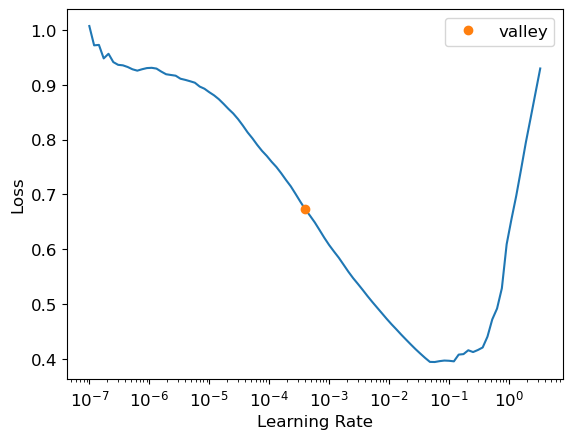

In [36]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [37]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063349,0.061547,00:12
1,0.054305,0.055277,00:12
2,0.048426,0.053023,00:12
3,0.043608,0.051838,00:12
4,0.040091,0.050707,00:11


We can use our `r_mse` function to compare the result to the random forest result we got earlier:

In [38]:
# Function to calculate the RMSE
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [39]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.225181

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).

Before we move on, let's save our model in case we want to come back to it again later:

In [40]:
learn.save('nn')

Path('models/nn.pth')